# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig

## Introduction

Three dimensions!

## The Grizzly Bear Problem

In 1996 and 1997 Mowat and Strobeck deployed bear traps in locations in British Columbia and Alberta, in an effort to estimate the population of grizzly bears.  They describe the experiment in "[Estimating Population Size of Grizzly Bears Using Hair Capture, DNA Profiling, and Mark-Recapture Analysis](https://www.researchgate.net/publication/229195465_Estimating_Population_Size_of_Grizzly_Bears_Using_Hair_Capture_DNA_Profiling_and_Mark-Recapture_Analysis)"

The "trap" consists of  a lure and several strands of barbed wire intended to capture samples of hair from bears that visit the lure.  Using the hair samples, the researchers use DNA analysis to identify individual bears.

During the first session, on June 29, 1996, the researchers deployed traps at 76 sites.  Returning 10 days later, they obtained 1043 hair samples and identified 23 different bears.  During a second 10-day session they obtained 1191 samples from 19 different bears, where 4 of the 19 were from bears they had identified in the first batch.

To estimate the population of bears from this data, we need a model for the probability that each bear will be observed during each session.  As a starting place, we'll make the simplest assumption, that every bear in the population has the same (unknown) probability of being sampled during each round.

With these assumptions we can compute the probability of the data for a range of possible populations.
Suppose we know that the population of bears is 200.

After the first session, 23 of the 200 bears have been identified.
During the second session, 19 bears were observed.
What is the probability that 4 of them had been previously identified.


I'll define

* N: actual (unknown) population size, 200

* K: number of bears identified in the first session, 23

* n: number of bears observed in the second session, 19 in the example

* k: the number of bears in the second session that had previously been identified, 4


For given values of N, K, and n, the distribution of k is described by the [hypergeometric distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution):

$PMF(k) = {K \choose k}{N-K \choose n-k}/{N \choose n}$

To understand why, let's start with the denominator, ${ N \choose n}$, which is the number of subsets of $n$ we could choose from a population of $N$ bears.

The numerator is the number of subsets that contain $k$ bears chosen from the previously identified $K$, and $n-k$ chosen from the previously unseen $N-K$.

SciPy provides `hypergeom`, which we can use to compute this PMF.

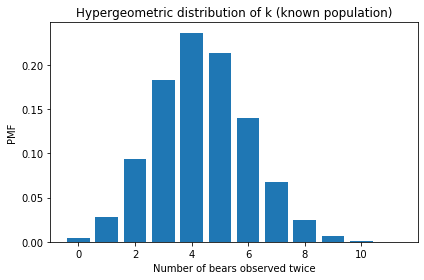

In [4]:
from scipy.stats import hypergeom

N = 100
K = 23
n = 19

ks = np.arange(12)
ps = hypergeom(N, K, n).pmf(ks)

plt.bar(ks, ps)

decorate(xlabel='Number of bears observed twice',
         ylabel='PMF',
         title='Hypergeometric distribution of k (known population)')

So that's the distribution of `k` given `N`, `K`, and `n`.
Now let's go the other way: given `K`, `n`, and `k`, how can we estimate the total population, `N`.

As a starting place, let's suppose that, prior to this study, an expert in this domain would have estimated that the population is between 50 and 500, and equally likely to be any value in that range.

In [5]:
Ns = np.arange(50, 501)
prior_N = Pmf(1, Ns)
prior_N.index.name = 'N'

In [6]:
K = 23
n = 19
k = 4

likelihood = hypergeom(Ns, K, n).pmf(k)

In [7]:
posterior_N = prior_N * likelihood
posterior_N.normalize()

34.97606148975133

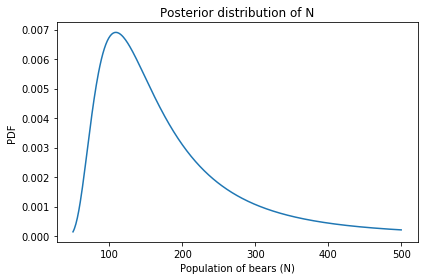

In [8]:
posterior_N.plot()

decorate(xlabel='Population of bears (N)',
         ylabel='PDF',
         title='Posterior distribution of N')

In [9]:
posterior_N.max_prob()

109

In [10]:
posterior_N.mean()

173.79880627085643

In [11]:
posterior_N.credible_interval(0.9)

array([ 77., 363.])

## Two parameter model


In [12]:
ps = np.linspace(0, 1, 101)
prior_p = Pmf(1, ps)
prior_p.index.name = 'p'

In [13]:
from utils import make_joint

joint_prior = make_joint(prior_N, prior_p)

In [14]:
N_mesh, p_mesh = np.meshgrid(Ns, ps)
N_mesh.shape

(101, 451)

In [15]:
from scipy.stats import binom

like1 = binom.pmf(K, N_mesh, p_mesh)
like1.sum()

229.56130903199954

In [16]:
like2 = binom.pmf(k, K, p_mesh) * binom.pmf(n-k, N_mesh-K, p_mesh)
like2.sum()

24.771767481921685

In [17]:
from utils import normalize

joint_posterior = joint_prior * like1 * like2
normalize(joint_posterior)

In [18]:
def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel=joint.columns.name, 
             ylabel=joint.index.name)
    return cs

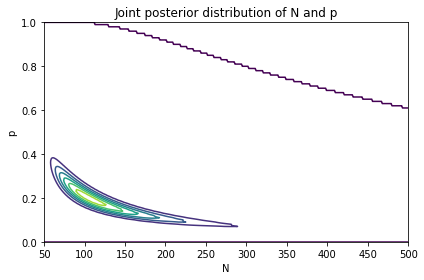

In [19]:
plot_contour(joint_posterior)

decorate(title='Joint posterior distribution of N and p')

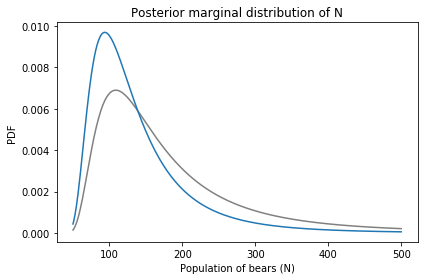

In [20]:
from utils import marginal

marginal_N = marginal(joint_posterior, 0)

posterior_N.plot(color='gray')
marginal_N.plot()

decorate(xlabel='Population of bears (N)',
         ylabel='PDF',
         title='Posterior marginal distribution of N')

In [21]:
marginal_N.mean(), marginal_N.credible_interval(0.9)

(138.7505213647261, array([ 68., 277.]))

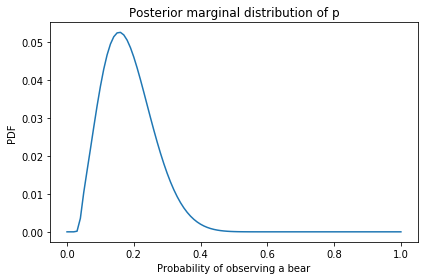

In [22]:
marginal_p = marginal(joint_posterior, 1)
marginal_p.plot()

decorate(xlabel='Probability of observing a bear',
         ylabel='PDF',
         title='Posterior marginal distribution of p')

In [23]:
from seaborn import JointGrid

def joint_plot(joint, **options):
    x = joint.columns.name
    x = 'x' if x is None else x

    y = joint.index.name
    y = 'y' if y is None else y

    # make a JointGrid with minimal data
    data = pd.DataFrame({x:[0], y:[0]})
    g = JointGrid(x, y, data, **options)

    # replace the contour plot
    g.ax_joint.contour(joint.columns, 
                   joint.index, 
                   joint, 
                   cmap='viridis')
    
    # replace the marginals
    marginal_x = marginal(joint, 0)
    g.ax_marg_x.plot(marginal_x.qs, marginal_x.ps)
    
    marginal_y = marginal(joint, 1)
    g.ax_marg_y.plot(marginal_y.ps, marginal_y.qs)

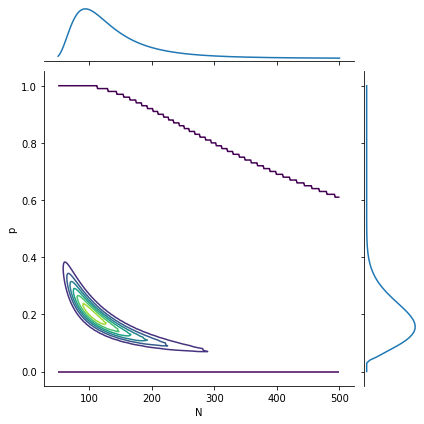

In [24]:
joint_plot(joint_posterior)

## Two parameters better than one?

In [25]:
mean = (23 + 19) / 2
N1 = 138
p = mean/N1
p

0.15217391304347827

In [26]:
from scipy.stats import binom

binom(N1, p).std()

4.219519857292647

In [27]:
binom(N1, p).pmf([23, 19]).prod()

0.007113233315460428

In [28]:
N2 = 173
p = mean/N2
p

0.12138728323699421

In [29]:
binom(N2, p).std()

4.2954472470306415

In [30]:
binom(N2, p).pmf([23, 19]).prod()

0.006918408214247037

## The Lincoln index problem

A few years ago my occasional correspondent John D. Cook wrote an excellent
blog post about the Lincoln index, which is a way to estimate the
number of errors in a document (or program) by comparing results from
two independent testers. 

http://www.johndcook.com/blog/2010/07/13/lincoln-index/

Here's his presentation of the problem:

>"Suppose you have a tester who finds 20 bugs in your program. You
want to estimate how many bugs are really in the program. You know
there are at least 20 bugs, and if you have supreme confidence in your
tester, you may suppose there are around 20 bugs. But maybe your
tester isn't very good. Maybe there are hundreds of bugs. How can you
have any idea how many bugs there are? There's no way to know with one
tester. But if you have two testers, you can get a good idea, even if
you don't know how skilled the testers are."

Suppose the first tester finds 20 bugs, the second finds 15, and they
find 3 in common; how can we estimate the number of bugs?

In [447]:
n0 = 20
n1 = 15
k11 = 3

In [448]:
k10 = n0 - k11
k01 = n1 - k11

k10, k01

(17, 12)

In [449]:
Ns = np.arange(32, 350)
prior_N = Pmf(1, Ns)
prior_N.index.name = 'N'

In [450]:
p0, p1 = 0.2, 0.15

like0 = binom.pmf(n0, Ns, p0)
like0.sum()

4.9999998675182855

In [451]:
like1 = binom.pmf(k01, Ns-n0, p1) * binom.pmf(k11, n0, p1)
like1.sum()

1.6188593076346907

In [452]:
likelihood = like0 * like1
likelihood.shape

(318,)

In [453]:
prior_N.shape

(318,)

In [454]:
posterior_N = prior_N * likelihood
posterior_N.normalize()

0.10960645032182464

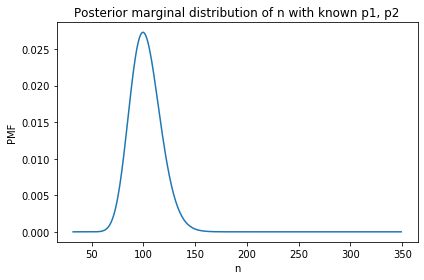

In [455]:
posterior_N.plot()

decorate(xlabel='n',
         ylabel='PMF',
         title='Posterior marginal distribution of n with known p1, p2')

In [456]:
posterior_N.mean()

102.12500000000003

## Unknown probabilities

In [457]:
p0 = np.linspace(0, 1, 61)
prior_p0 = Pmf(1, p0)
prior_p0.index.name = 'p0'

In [458]:
p1 = np.linspace(0, 1, 51)
prior_p1 = Pmf(1, p1)
prior_p1.index.name = 'p1'

In [459]:
from utils import make_joint

joint = make_joint(prior_p0, prior_p1)
joint.shape

(51, 61)

In [460]:
joint_pmf = Pmf(joint.transpose().stack())
joint_pmf.head()

p0   p1  
0.0  0.00    1
     0.02    1
     0.04    1
     0.06    1
     0.08    1
dtype: int64

In [461]:
joint_prior = make_joint(prior_N, joint_pmf)
joint_prior.shape

(3111, 318)

In [462]:
joint_prior.head()

N         32   33   34   35   36   37   38   39   40   41   ...  340  341  \
p0  p1                                                      ...             
0.0 0.00    1    1    1    1    1    1    1    1    1    1  ...    1    1   
    0.02    1    1    1    1    1    1    1    1    1    1  ...    1    1   
    0.04    1    1    1    1    1    1    1    1    1    1  ...    1    1   
    0.06    1    1    1    1    1    1    1    1    1    1  ...    1    1   
    0.08    1    1    1    1    1    1    1    1    1    1  ...    1    1   

N         342  343  344  345  346  347  348  349  
p0  p1                                            
0.0 0.00    1    1    1    1    1    1    1    1  
    0.02    1    1    1    1    1    1    1    1  
    0.04    1    1    1    1    1    1    1    1  
    0.06    1    1    1    1    1    1    1    1  
    0.08    1    1    1    1    1    1    1    1  

[5 rows x 318 columns]

In [475]:
likelihood = joint_prior.copy()
Ns = joint_prior.columns

for (p0, p1) in joint_prior.index:
    like0 = binom.pmf(n0, Ns, p0)
    like1 = binom.pmf(k01, Ns-n0, p1) * binom.pmf(k11, n0, p1)
    likelihood.loc[p0, p1] = like0 * like1
    
likelihood.to_numpy().sum()

8.930285561728951

In [476]:
from utils import normalize

joint_posterior = joint_prior * likelihood
normalize(joint_posterior)
joint_posterior.shape

(3111, 318)

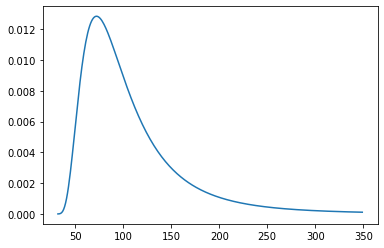

In [477]:
from utils import marginal

posterior_N = marginal(joint_posterior, 0)
posterior_N.plot()

In [478]:
posterior_pmf = marginal(joint_posterior, 1)
posterior_pmf.shape

(3111,)

In [479]:
posterior_joint_ps = posterior_pmf.unstack().transpose()
posterior_joint_ps.head()

p0,0.000000,0.016667,0.033333,0.050000,0.066667,0.083333,0.100000,0.116667,0.133333,0.150000,...,0.850000,0.866667,0.883333,0.900000,0.916667,0.933333,0.950000,0.966667,0.983333,1.000000
p1,,,,,,,,,,,,,,,,,,,,,
0.00,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
0.02,0.0,4.015401e-10,0.000002,0.000032,0.000050,0.000025,0.000007,0.000002,5.060290e-07,1.416566e-07,...,6.400273e-25,1.228006e-25,1.958740e-26,2.449499e-27,2.193235e-28,1.207843e-29,3.077500e-31,1.914739e-33,3.786697e-37,0.0
0.04,0.0,1.890324e-08,0.000105,0.001978,0.004170,0.003270,0.001700,0.000760,3.213970e-04,1.333903e-04,...,1.315527e-20,2.561670e-21,4.144637e-22,5.254755e-23,4.767778e-24,2.659487e-25,6.860462e-27,4.319699e-29,8.642163e-33,0.0
0.06,0.0,1.196881e-08,0.000081,0.002099,0.007045,0.009668,0.008665,0.006179,3.852341e-03,2.210927e-03,...,3.588320e-18,7.090774e-19,1.163614e-19,1.495587e-20,1.375016e-21,7.768342e-23,2.028796e-24,1.292760e-26,2.616374e-30,0.0
0.08,0.0,1.471051e-09,0.000014,0.000600,0.003545,0.008300,0.011721,0.012207,1.046347e-02,7.875544e-03,...,1.660452e-16,3.329404e-17,5.541137e-18,7.219543e-19,6.725358e-20,3.848194e-21,1.017439e-22,6.560825e-25,1.343223e-28,0.0


In [480]:
def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel=joint.columns.name, 
             ylabel=joint.index.name)
    return cs

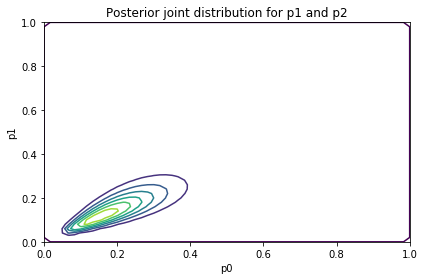

In [481]:
plot_contour(posterior_joint_ps)
decorate(title='Posterior joint distribution for p1 and p2')

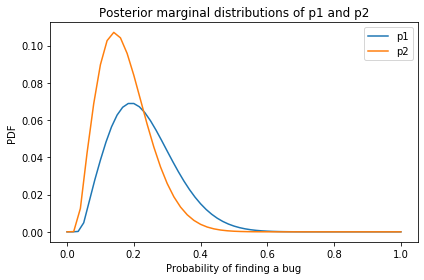

In [482]:
posterior_p1 = marginal(posterior_joint_ps, 0)
posterior_p2 = marginal(posterior_joint_ps, 1)

posterior_p1.plot(label='p1')
posterior_p2.plot(label='p2')
decorate(xlabel='Probability of finding a bug',
         ylabel='PDF',
         title='Posterior marginal distributions of p1 and p2')

In [483]:
posterior_p1.mean(), posterior_p1.credible_interval(0.9)

(0.22970406720316164, array([0.1, 0.4]))

In [484]:
posterior_p2.mean(), posterior_p2.credible_interval(0.9)

(0.17501024717938662, array([0.06, 0.32]))

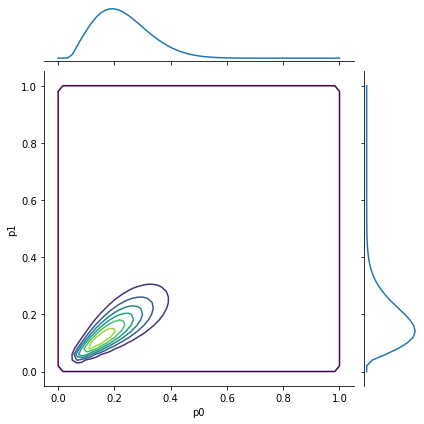

In [485]:
joint_plot(posterior_joint_ps)

## Chao et al

In [57]:
data = [-1000, 63, 55, 18, 69, 17, 21, 28]

In [58]:
index = pd.MultiIndex.from_product([[0, 1]]*3)

In [59]:
Kijk = pd.Series(data, index)
Kijk

0  0  0   -1000
      1      63
   1  0      55
      1      18
1  0  0      69
      1      17
   1  0      21
      1      28
dtype: int64

In [60]:
Kijk.xs(1, level=0).sum()

135

In [61]:
Kijk.xs(1, level=1).sum()

122

In [62]:
Kijk.xs(1, level=2).sum()

126

In [63]:
n = pd.Series(1, range(3))

for level in n.index:
    n[level] = Kijk.xs(1, level=level).sum()
    
n

0    135
1    122
2    126
dtype: int64

In [64]:
Kixx = Kijk.sum(level=0)
Kixx

0   -864
1    135
dtype: int64

In [65]:
Kijx = Kijk.sum(level=[0,1])
Kijx

0  0   -937
   1     73
1  0     86
   1     49
dtype: int64

In [66]:
def num_observed(K):
    return np.asarray(K)[1:].sum()

In [67]:
s0 = num_observed(Kixx)
s0

135

In [68]:
s1 = num_observed(Kijx)
s1

208

In [69]:
s2 = num_observed(Kijk)
s2

271

In [70]:
s = [s0, s1, s2]
s

[135, 208, 271]

In [71]:
k = pd.concat([Kixx, Kijx, Kijk])
k

0            -864
1             135
(0, 0)       -937
(0, 1)         73
(1, 0)         86
(1, 1)         49
(0, 0, 0)   -1000
(0, 0, 1)      63
(0, 1, 0)      55
(0, 1, 1)      18
(1, 0, 0)      69
(1, 0, 1)      17
(1, 1, 0)      21
(1, 1, 1)      28
dtype: int64

In [72]:
k[1]

135

In [73]:
k[0,1]

73

In [74]:
k[0,0,1]

63

In [75]:
k[0]

-864

In [76]:
N = 300
k0 = N - s[0]
k0

165

In [77]:
k00 = N - s[1]
k00

92

In [78]:
k000 = N - s[2]
k000

29

In [79]:
Ns = np.arange(s2, 500, 5)
prior_N = Pmf(1, Ns)
prior_N.index.name = 'N'

In [80]:
ps = np.linspace(0, 1, 101)
prior_p = Pmf(1, ps)
prior_p.index.name = 'p'

In [81]:
from utils import make_joint

joint_prior = make_joint(prior_N, prior_p)

In [82]:
def likelihood_round1(ps, n, k, s, joint_prior):

    like = joint_prior.copy()

    for N in joint_prior:
        like[N] = binom.pmf(n[0], N, ps)
    return like

In [83]:
like1 = likelihood_round1(ps, n, k, s, joint_prior)

In [84]:
def likelihood_round2(ps, n, k, s, joint_prior):
    like = joint_prior.copy()

    for N in joint_prior:
        k0 = N - s[0]
        like[N] = (binom.pmf(k[0,1], k0, ps) * 
                   binom.pmf(k[1,1], k[1], ps))
    return like

In [85]:
like2 = likelihood_round2(ps, n, k, s, joint_prior)
like2.to_numpy().sum()

0.40773670523278144

In [86]:
joint_posterior2 = joint_prior * like1 * like2
normalize(joint_posterior2)

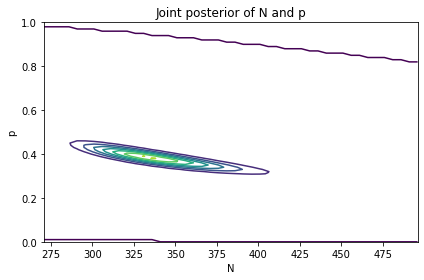

In [87]:
plot_contour(joint_posterior2)
decorate(title='Joint posterior of N and p')

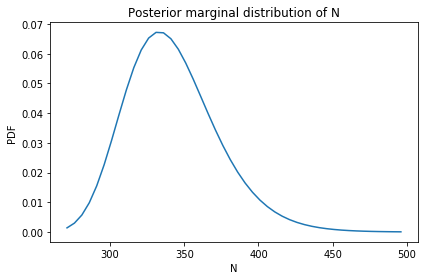

In [88]:
marginal_N = marginal(joint_posterior2, 0)
marginal_N.plot()

decorate(xlabel='N',
         ylabel='PDF',
         title='Posterior marginal distribution of N')

In [89]:
marginal_N.mean(), marginal_N.credible_interval(0.9)

(342.19942566476345, array([296., 396.]))

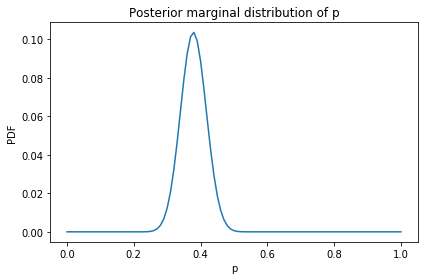

In [90]:
marginal_p = marginal(joint_posterior2, 1)
marginal_p.plot()

decorate(xlabel='p',
         ylabel='PDF',
         title='Posterior marginal distribution of p')

In [91]:
def likelihood_round3(ps, n, k, s, joint_prior):
    like = joint_prior.copy()

    for N in joint_prior:
        k00 = N - s[1]
        like[N] = (binom.pmf(k[0,0,1], k00, ps) * 
                   binom.pmf(k[0,1,1], k[0,1], ps) * 
                   binom.pmf(k[1,0,1], k[1,0], ps) * 
                   binom.pmf(k[1,1,1], k[1,1], ps))
    return like

In [92]:
like3 = likelihood_round3(ps, n, k, s, joint_prior)
like3.to_numpy().sum()

1.7620042777092345e-07

In [93]:
joint_posterior3 = joint_posterior2 * like3
normalize(joint_posterior3)

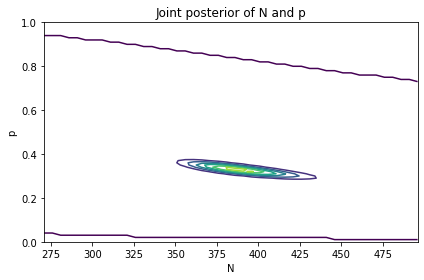

In [94]:
plot_contour(joint_posterior3)
decorate(title='Joint posterior of N and p')

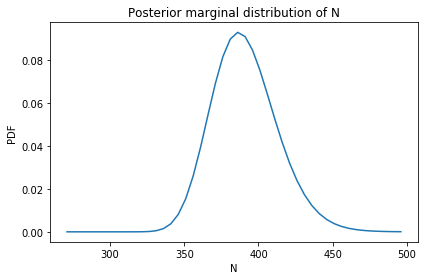

In [95]:
marginal_N = marginal(joint_posterior3, 0)
marginal_N.plot()

decorate(xlabel='N',
         ylabel='PDF',
         title='Posterior marginal distribution of N')

In [96]:
marginal_N.mean(), marginal_N.credible_interval(0.9)

(391.0058839098183, array([356., 431.]))

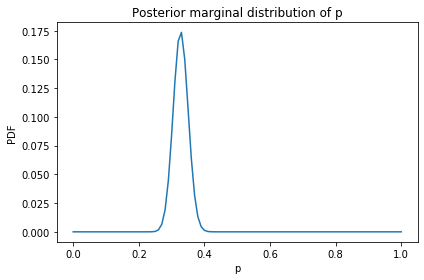

In [97]:
marginal_p = marginal(joint_posterior3, 1)
marginal_p.plot()

decorate(xlabel='p',
         ylabel='PDF',
         title='Posterior marginal distribution of p')

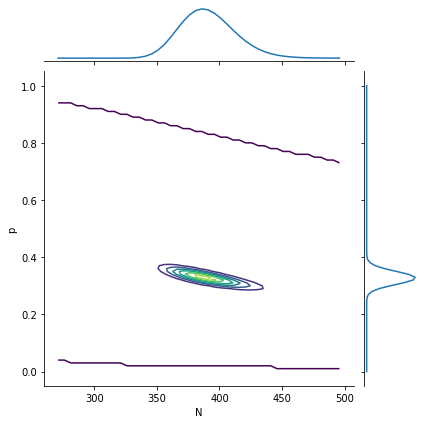

In [98]:
joint_plot(joint_posterior3)

## Spina bifida

In [256]:
data_sb = [-100, 60, 49, 4, 247, 112, 142, 12]
num_observed(data_sb)

626

In [258]:
def make_stats(data, num_rounds):
    index = pd.MultiIndex.from_product([[0, 1]]*num_rounds)

    K = pd.Series(data, index)

    n = pd.Series(0, range(num_rounds))
    for level in n.index:
        n[level] = K.xs(1, level=level).sum()
    
    t = [K.sum(level=list(range(i+1)))
         for i in range(num_rounds)]
    
    s = [num_observed(Kx) for Kx in t]
        
    k = pd.concat(t)
    return n, k, s

In [259]:
n, k, s = make_stats(data_sb, 3)

In [260]:
n

0    513
1    207
2    188
dtype: int64

In [261]:
k

0             13
1            513
(0, 0)       -40
(0, 1)        53
(1, 0)       359
(1, 1)       154
(0, 0, 0)   -100
(0, 0, 1)     60
(0, 1, 0)     49
(0, 1, 1)      4
(1, 0, 0)    247
(1, 0, 1)    112
(1, 1, 0)    142
(1, 1, 1)     12
dtype: int64

In [262]:
s

[513, 566, 626]

## 

In [556]:
s[2]

626

In [557]:
Ns = np.arange(s[2], 1000, 10)
prior_N = Pmf(1, Ns)
prior_N.index.name = 'N'
prior_N.shape

(38,)

In [558]:
probs1 = np.linspace(0, 1, 61)
prior_p1 = Pmf(1, probs1)
prior_p1.index.name = 'p1'

In [559]:
probs2 = np.linspace(0, 1, 51)
prior_p2 = Pmf(1, probs2)
prior_p2.index.name = 'p2'

In [560]:
probs3 = np.linspace(0, 1, 41)
prior_p3 = Pmf(1, probs3)
prior_p3.index.name = 'p3'

In [561]:
def make_joint3(prior0, prior1, prior2):
    joint2 = make_joint(prior0, prior1)
    joint2_pmf = Pmf(joint2.transpose().stack())
    joint3 = make_joint(prior2, joint_pmf)
    return joint3

In [562]:
joint_prior = make_joint3(prior_p0, prior_p1, prior_N)
joint_prior.head()

N         626  636  646  656  666  676  686  696  706  716  ...  906  916  \
p0  p1                                                      ...             
0.0 0.00    1    1    1    1    1    1    1    1    1    1  ...    1    1   
    0.02    1    1    1    1    1    1    1    1    1    1  ...    1    1   
    0.04    1    1    1    1    1    1    1    1    1    1  ...    1    1   
    0.06    1    1    1    1    1    1    1    1    1    1  ...    1    1   
    0.08    1    1    1    1    1    1    1    1    1    1  ...    1    1   

N         926  936  946  956  966  976  986  996  
p0  p1                                            
0.0 0.00    1    1    1    1    1    1    1    1  
    0.02    1    1    1    1    1    1    1    1  
    0.04    1    1    1    1    1    1    1    1  
    0.06    1    1    1    1    1    1    1    1  
    0.08    1    1    1    1    1    1    1    1  

[5 rows x 38 columns]

In [563]:
likelihood = joint_prior.copy()
Ns = joint_prior.columns

for (p0, p1) in joint_prior.index:
    like0 = binom.pmf(k[1], Ns, p0)
    k0 = Ns - s[0]
    like1 = binom.pmf(k[0,1], k0, p1) * binom.pmf(k[1,1], k[1], p1)
    likelihood.loc[p0, p1] = like0 * like1
    
likelihood.to_numpy().sum()

0.002809941857845991

In [564]:
from utils import normalize

joint_posterior = joint_prior * likelihood
normalize(joint_posterior)
joint_posterior.shape

(3111, 38)

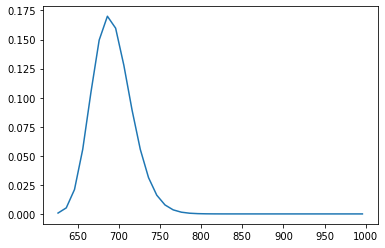

In [565]:
from utils import marginal

posterior_N = marginal(joint_posterior, 0)
posterior_N.plot()

In [566]:
posterior_pmf = marginal(joint_posterior, 1)
posterior_pmf.head()

p0   p1  
0.0  0.00    0.0
     0.02    0.0
     0.04    0.0
     0.06    0.0
     0.08    0.0
dtype: float64

In [567]:
posterior_joint_ps = posterior_pmf.unstack().transpose()
posterior_joint_ps.head()

p0,0.000000,0.016667,0.033333,0.050000,0.066667,0.083333,0.100000,0.116667,0.133333,0.150000,...,0.850000,0.866667,0.883333,0.900000,0.916667,0.933333,0.950000,0.966667,0.983333,1.000000
p1,,,,,,,,,,,,,,,,,,,,,
0.00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
0.02,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.855130e-309,...,7.682915e-185,6.760669e-188,2.575745e-191,2.735340e-195,2.478919e-200,2.647062e-207,1.753763e-217,1.660274e-233,1.028744e-263,0.0
0.04,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,3.925149e-302,2.229438e-276,3.283551e-254,...,1.316501e-126,1.493110e-129,7.210315e-133,9.121051e-137,8.875098e-142,9.618204e-149,6.383453e-159,6.043785e-175,3.744875e-205,0.0
0.06,0.0,0.0,0.0,0.0,0.0,0.000000e+00,2.557819e-303,6.772245e-273,3.846763e-247,5.665952e-225,...,2.668920e-94,3.893869e-97,2.371178e-100,3.525532e-104,3.647231e-109,4.001702e-116,2.659701e-126,2.518390e-142,1.560458e-172,0.0
0.08,0.0,0.0,0.0,0.0,0.0,1.758874e-321,7.962055e-285,2.108202e-254,1.197581e-228,1.764084e-206,...,1.194208e-72,2.236601e-75,1.706415e-78,2.940015e-82,3.204856e-87,3.552579e-94,2.364010e-104,2.238566e-120,1.387074e-150,0.0


In [568]:
def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel=joint.columns.name, 
             ylabel=joint.index.name)
    return cs

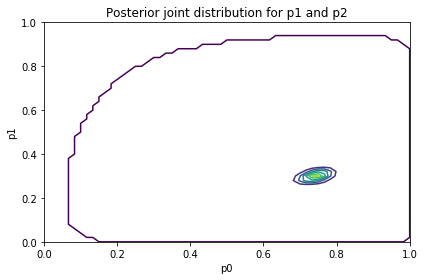

In [569]:
plot_contour(posterior_joint_ps)
decorate(title='Posterior joint distribution for p1 and p2')

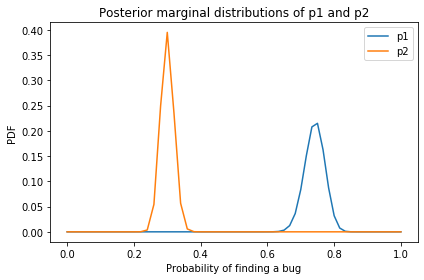

In [570]:
posterior_p1 = marginal(posterior_joint_ps, 0)
posterior_p2 = marginal(posterior_joint_ps, 1)

posterior_p1.plot(label='p1')
posterior_p2.plot(label='p2')
decorate(xlabel='Probability of finding a bug',
         ylabel='PDF',
         title='Posterior marginal distributions of p1 and p2')

In [571]:
joint3 = make_joint(prior_p2, posterior_pmf)
joint3.head()

p2        0.00  0.02  0.04  0.06  0.08  0.10  0.12  0.14  0.16  0.18  ...  \
p0  p1                                                                ...   
0.0 0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
    0.02   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
    0.04   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
    0.06   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
    0.08   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

p2        0.82  0.84  0.86  0.88  0.90  0.92  0.94  0.96  0.98  1.00  
p0  p1                                                                
0.0 0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
    0.02   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
    0.04   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
    0.06   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
    0.08   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 51 columns]

In [572]:
joint3_pmf = Pmf(joint3.stack())
joint3_pmf.head()

p0   p1   p2  
0.0  0.0  0.00    0.0
          0.02    0.0
          0.04    0.0
          0.06    0.0
          0.08    0.0
dtype: float64

In [573]:
prior4 = make_joint(posterior_N, joint3_pmf)
prior4.head()

N             626  636  646  656  666  676  686  696  706  716  ...  906  916  \
p0  p1  p2                                                      ...             
0.0 0.0 0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
        0.02  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
        0.04  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
        0.06  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
        0.08  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

N             926  936  946  956  966  976  986  996  
p0  p1  p2                                            
0.0 0.0 0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        0.02  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        0.04  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        0.06  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        0.08  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 38 columns]

In [574]:
prior4.shape

(158661, 38)

In [576]:
joint2 = make_joint(posterior_N, prior_p2)
joint2.head()

N,626,636,646,656,666,676,686,696,706,716,...,906,916,926,936,946,956,966,976,986,996
p2,,,,,,,,,,,,,,,,,,,,,
0.00,0.000753,0.005198,0.020981,0.055512,0.104628,0.149534,0.170043,0.159773,0.127842,0.089262,...,1.397201e-09,4.333679e-10,1.336876e-10,4.106060e-11,1.256866e-11,3.837917e-12,1.170159e-12,3.565415e-13,1.086470e-13,3.313079e-14
0.02,0.000753,0.005198,0.020981,0.055512,0.104628,0.149534,0.170043,0.159773,0.127842,0.089262,...,1.397201e-09,4.333679e-10,1.336876e-10,4.106060e-11,1.256866e-11,3.837917e-12,1.170159e-12,3.565415e-13,1.086470e-13,3.313079e-14
0.04,0.000753,0.005198,0.020981,0.055512,0.104628,0.149534,0.170043,0.159773,0.127842,0.089262,...,1.397201e-09,4.333679e-10,1.336876e-10,4.106060e-11,1.256866e-11,3.837917e-12,1.170159e-12,3.565415e-13,1.086470e-13,3.313079e-14
0.06,0.000753,0.005198,0.020981,0.055512,0.104628,0.149534,0.170043,0.159773,0.127842,0.089262,...,1.397201e-09,4.333679e-10,1.336876e-10,4.106060e-11,1.256866e-11,3.837917e-12,1.170159e-12,3.565415e-13,1.086470e-13,3.313079e-14
0.08,0.000753,0.005198,0.020981,0.055512,0.104628,0.149534,0.170043,0.159773,0.127842,0.089262,...,1.397201e-09,4.333679e-10,1.336876e-10,4.106060e-11,1.256866e-11,3.837917e-12,1.170159e-12,3.565415e-13,1.086470e-13,3.313079e-14


In [577]:
like2 = joint2.copy()
Ns = joint2.columns

for p2 in joint2.index:
    k00 = Ns - s[1]
    like = (binom.pmf(k[0,0,1], k00, p2) * 
            binom.pmf(k[0,1,1], k[0,1], p2) * 
            binom.pmf(k[1,0,1], k[1,0], p2) * 
            binom.pmf(k[1,1,1], k[1,1], p2))
    
    like2.loc[p2] = like

In [578]:
like2.head()

N,626,636,646,656,666,676,686,696,706,716,...,906,916,926,936,946,956,966,976,986,996
p2,,,,,,,,,,,,,,,,,,,,,
0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0.02,1.056117e-205,3.423262e-194,2.492654e-187,3.877888e-182,6.470516e-178,2.413703e-174,3.036134e-171,1.665907e-168,4.742482e-166,7.922126e-164,...,1.348622e-140,7.424037e-140,3.852880e-139,1.891759e-138,8.816277e-138,3.911366e-137,1.656431e-136,6.712795e-136,2.609254e-135,9.748418e-135
0.04,4.955988e-153,1.307103e-141,7.744318e-135,9.803206e-130,1.330955e-125,4.039800e-122,4.134742e-119,1.845992e-116,4.275987e-114,5.811979e-112,...,1.967671e-90,8.813611e-90,3.721781e-89,1.486903e-88,5.638372e-88,2.035394e-87,7.013666e-87,2.312739e-86,7.314609e-86,2.223619e-85
0.06,6.244344e-124,1.334235e-112,6.404307e-106,6.567851e-101,7.224115e-97,1.776427e-93,1.472998e-90,5.327823e-88,9.998216e-86,1.100972e-83,...,6.825943e-64,2.477025e-63,8.474098e-63,2.742784e-62,8.426142e-62,2.464278e-61,6.879432e-61,1.837809e-60,4.709026e-60,1.159756e-59
0.08,1.559688e-104,2.687715e-93,1.040453e-86,8.605447e-82,7.633691e-78,1.513900e-74,1.012399e-71,2.953241e-69,4.469628e-67,3.969401e-65,...,4.135293e-47,1.210246e-46,3.339155e-46,8.716344e-46,2.159590e-45,5.093685e-45,1.146818e-44,2.470826e-44,5.105903e-44,1.014163e-43


In [580]:
like2.to_numpy().sum()

7.185821914837763e-14

In [583]:
prior4.columns

Int64Index([626, 636, 646, 656, 666, 676, 686, 696, 706, 716, 726, 736, 746,
            756, 766, 776, 786, 796, 806, 816, 826, 836, 846, 856, 866, 876,
            886, 896, 906, 916, 926, 936, 946, 956, 966, 976, 986, 996],
           dtype='int64', name='N')

In [584]:
like2.columns

Int64Index([626, 636, 646, 656, 666, 676, 686, 696, 706, 716, 726, 736, 746,
            756, 766, 776, 786, 796, 806, 816, 826, 836, 846, 856, 866, 876,
            886, 896, 906, 916, 926, 936, 946, 956, 966, 976, 986, 996],
           dtype='int64', name='N')

In [ ]:
posterior4 = prior4.copy()

for (p0, p1, p2) in prior4.index:
    posterior4.loc[p0, p1, p2] = (prior4.loc[p0, p1, p2] *
                                  like2.loc[p2].to_numpy())
    
posterior4.to_numpy().sum()

In [521]:
#joint_posterior2 = prior4 * like2
#normalize(joint_posterior2)

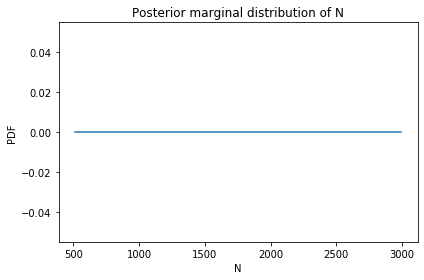

In [522]:
marginal_N = marginal(joint_posterior2, 0)
marginal_N.plot()

decorate(xlabel='N',
         ylabel='PDF',
         title='Posterior marginal distribution of N')

## Failed attempt

In [309]:
prior_p1 = Pmf(1, ps)
prior_p1.index.name = 'p1'

In [310]:
prior_p2 = Pmf(1, ps)
prior_p2.index.name = 'p2'

In [311]:
prior2 = make_joint(prior_p0, prior_p1)
joint_pmf = Pmf(prior2.transpose().stack())
joint_pmf.head()

p0   p1      
0.0  0.000000    1
     0.033333    1
     0.066667    1
     0.100000    1
     0.133333    1
dtype: int64

In [312]:
prior3 = make_joint(joint_pmf, prior_p2)
joint_pmf = Pmf(prior3.transpose().stack())
joint_pmf.head()

p0   p1   p2      
0.0  0.0  0.000000    1
          0.033333    1
          0.066667    1
          0.100000    1
          0.133333    1
dtype: int64

In [313]:
prior4 = make_joint(prior_N, joint_pmf)
prior4.shape

(29791, 50)

In [314]:
prior4.head()

N                 1000  1020  1040  1060  1080  1100  1120  1140  1160  1180  \
p0  p1  p2                                                                     
0.0 0.0 0.000000     1     1     1     1     1     1     1     1     1     1   
        0.033333     1     1     1     1     1     1     1     1     1     1   
        0.066667     1     1     1     1     1     1     1     1     1     1   
        0.100000     1     1     1     1     1     1     1     1     1     1   
        0.133333     1     1     1     1     1     1     1     1     1     1   

N                 ...  1800  1820  1840  1860  1880  1900  1920  1940  1960  \
p0  p1  p2        ...                                                         
0.0 0.0 0.000000  ...     1     1     1     1     1     1     1     1     1   
        0.033333  ...     1     1     1     1     1     1     1     1     1   
        0.066667  ...     1     1     1     1     1     1     1     1     1   
        0.100000  ...     1     1     1     1     1     1     1     1     1   
        0.133333  ...     1     1     1     1     1     1     1     1     1   

N                 1980  
p0  p1  p2              
0.0 0.0 0.000000     1  
        0.033333     1  
        0.066667     1  
        0.100000     1  
        0.133333     1  

[5 rows x 50 columns]

In [315]:
k[1]

513

In [352]:
Ns = np.arange(s[0]+1, 3000, 20)
prior_N = Pmf(1, Ns)
prior_N.index.name = 'N'
prior_N.shape

(125,)

In [353]:
ps = np.linspace(0, 1, 101)
prior_p0 = Pmf(1, ps)
prior_p0.index.name = 'p0'

In [354]:
prior0 = make_joint(prior_N, prior_p0)
prior0.head()

N,514,534,554,574,594,614,634,654,674,694,...,2814,2834,2854,2874,2894,2914,2934,2954,2974,2994
p0,,,,,,,,,,,,,,,,,,,,,
0.00,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0.01,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0.02,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0.03,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
0.04,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [355]:
like0 = prior0.copy()
Ns = prior0.columns

for p0 in prior0.index:
    like0.loc[p0] = binom.pmf(k[1], Ns, p0)
    
like0.to_numpy().sum()

8.752870018319545

In [356]:
posterior0 = prior0 * like0
normalize(posterior0)

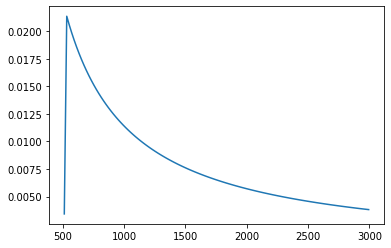

In [357]:
marginal_N = marginal(posterior0, 0)
marginal_N.plot()

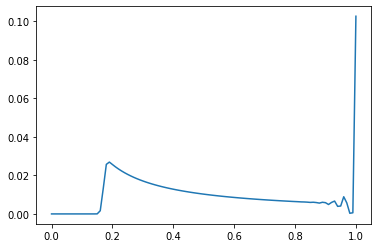

In [350]:
marginal_p0 = marginal(posterior0, 1)
marginal_p0.plot()

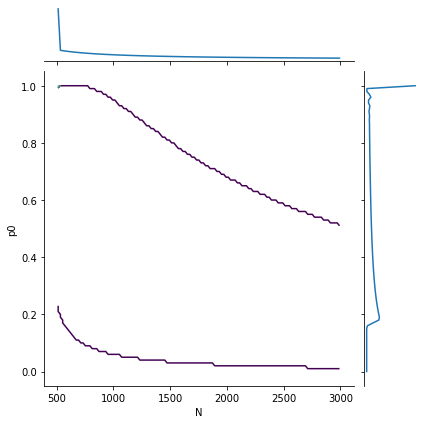

In [351]:
joint_plot(posterior0)

In [325]:
like1 = prior4.copy()

for (p0, p1, p2) in prior4.index:
    k0 = Ns - s[0]
    like1.loc[p0, p1, p2] = (binom.pmf(k[0,1], k0, p1) * 
                             binom.pmf(k[1,1], k[1], p1))
    
like1.to_numpy().sum()

Int64Index([ 487,  507,  527,  547,  567,  587,  607,  627,  647,  667,  687,
             707,  727,  747,  767,  787,  807,  827,  847,  867,  887,  907,
             927,  947,  967,  987, 1007, 1027, 1047, 1067, 1087, 1107, 1127,
            1147, 1167, 1187, 1207, 1227, 1247, 1267, 1287, 1307, 1327, 1347,
            1367, 1387, 1407, 1427, 1447, 1467],
           dtype='int64', name='N')
53
154
513


1489550

In [320]:
posterior1 = prior4 * like1
normalize(posterior1)

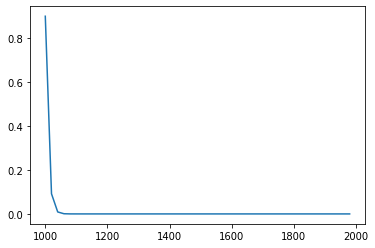

In [321]:
marginal_N = marginal(posterior1, 0)
marginal_N.plot()

In [280]:
like2 = prior4.copy()

for (p0, p1, p2) in prior4.index:
    k00 = Ns - s[1]
    like = (binom.pmf(k[0,0,1], k00, p2) * 
            binom.pmf(k[0,1,1], k[0,1], p2) * 
            binom.pmf(k[1,0,1], k[1,0], p2) * 
            binom.pmf(k[1,1,1], k[1,1], p2))
    
    like2.loc[p0, p1, p2] = like
    
like2.to_numpy().sum()

9.82403748698076e-16

In [281]:
posterior4 = prior4 * like0 * like1 * like2
normalize(posterior4)

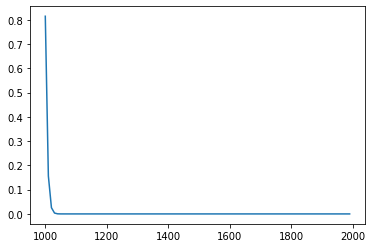

In [282]:
marginal_N = marginal(posterior4, 0)
marginal_N.plot()

k000 = N - s[2]
like4 = (comb(k000,     k[0,0,0,1]) * 
                   comb(k[0,0,1], k[0,0,1,1]) * 
                   comb(k[0,1,0], k[0,1,0,1]) * 
                   comb(k[0,1,1], k[0,1,1,1]) * 
                   comb(k[1,0,0], k[1,0,0,1]) * 
                   comb(k[1,0,1], k[1,0,1,1]) * 
                   comb(k[1,1,0], k[1,1,0,1]) * 
                   comb(k[1,1,1], k[1,1,1,1]) * 
                   half_binom(n[3], N, p4))

In [182]:
posterior_N = prior_N * like0
posterior_N.normalize()

39.64163305200636

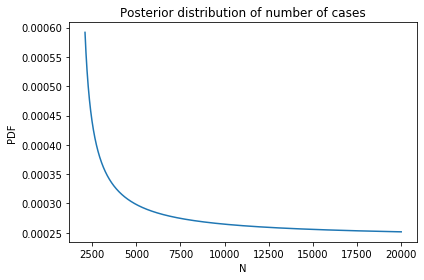

In [183]:
posterior_N.plot()

decorate(xlabel='N',
         ylabel='PDF',
         title='Posterior distribution of number of cases')

In [ ]:
## TODO: select the numerators and denominators

## Diabetes

In [141]:
data4 = [-10000, 10, 182, 8, 74, 7, 20, 14, 709, 12, 650, 46, 104, 18, 157, 58]
num_observed(data4)

2069

In [142]:
n, k, s = make_stats(data4, 4)

In [143]:
n

0    1754
1     452
2    1135
3     173
dtype: int64

In [144]:
k

0               -9685
1                1754
(0, 0)          -9800
(0, 1)            115
(1, 0)           1417
(1, 1)            337
(0, 0, 0)       -9990
(0, 0, 1)         190
(0, 1, 0)          81
(0, 1, 1)          34
(1, 0, 0)         721
(1, 0, 1)         696
(1, 1, 0)         122
(1, 1, 1)         215
(0, 0, 0, 0)   -10000
(0, 0, 0, 1)       10
(0, 0, 1, 0)      182
(0, 0, 1, 1)        8
(0, 1, 0, 0)       74
(0, 1, 0, 1)        7
(0, 1, 1, 0)       20
(0, 1, 1, 1)       14
(1, 0, 0, 0)      709
(1, 0, 0, 1)       12
(1, 0, 1, 0)      650
(1, 0, 1, 1)       46
(1, 1, 0, 0)      104
(1, 1, 0, 1)       18
(1, 1, 1, 0)      157
(1, 1, 1, 1)       58
dtype: int64

In [145]:
s

[1754, 1869, 2059, 2069]